In [2]:
# face verification with the VGGFace2 model
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import pandas as pd

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
    # load image from file
#     pixels = pyplot.imread(filename)
#     # create the detector, using default weights
#     detector = MTCNN()
#     # detect faces in the image
#     results = detector.detect_faces(pixels)
#     # extract the bounding box from the first face
#     x1, y1, width, height = results[0]['box']
#     x2, y2 = x1 + width, y1 + height
#     # extract the face
#     face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.open(filename)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

model = None
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
    # extract faces
    faces = [extract_face(f) for f in filenames]
    # convert into an array of samples
    samples = asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    # create a vggface model
    global model
    if not model:
        model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # perform prediction
    yhat = model.predict(samples)
    return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    if score <= thresh:
        print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
        return True, score
    else:
        print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
        return False, score

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import pandas as pd

In [4]:
BASE_PATH = pathlib.Path('../data/mfr2')
labels_path = BASE_PATH / 'mfr2_labels.txt'
pairs_path = BASE_PATH / 'pairs.txt'

In [5]:
labels=pd.read_csv(filepath_or_buffer=str(labels_path))
labels=labels.apply(lambda x: x.apply(lambda y: y.strip() if type(y) == type('') else y), axis=0)
people=labels["person"].unique()

def get_indexes(person, mask=True):
    if mask:
        mask_filter = labels["mask"]!="no-mask"
    else:
        mask_filter = labels["mask"]=="no-mask"
    person_filter = labels["person"]==person
    return list(labels[person_filter & mask_filter]["index"])

pairs={person:list(zip(get_indexes(person,mask=True), get_indexes(person, mask=False))) for person in people}

In [7]:
# with pairs_path.open() as f:
#     pairs_data = [l.strip().split(' ') for l in f.readlines() if l.strip()]

# pairs = []
# for pair_data in pairs_data:
#     if len(pair_data) == 3:
#         pairs.append(((pair_data[0], pair_data[1]), (pair_data[0], pair_data[2])))
#     elif len(pair_data) == 4:
#         pairs.append(((pair_data[0], pair_data[1]), (pair_data[2], pair_data[3])))
#     else:
#         print('wtf', pair_data)

In [7]:
results = []

# positive test
for person, pairs in pairs.items():
    for index1, index2 in pairs:
        path1 = BASE_PATH / person / f'{person}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person / f'{person}_{str(index2).rjust(4, "0")}.png'

        features1,features2=get_embeddings([path1, path2])
        matched, distance = is_match(features1, features2)

        results.append([pair, matched, distance])

>face is NOT a Match (0.526 > 0.500)
>face is NOT a Match (0.532 > 0.500)
>face is NOT a Match (0.567 > 0.500)
>face is NOT a Match (0.621 > 0.500)
>face is a Match (0.478 <= 0.500)
>face is NOT a Match (0.561 > 0.500)
>face is NOT a Match (0.682 > 0.500)
>face is NOT a Match (0.560 > 0.500)
>face is a Match (0.383 <= 0.500)
>face is a Match (0.327 <= 0.500)
>face is a Match (0.438 <= 0.500)
>face is NOT a Match (0.685 > 0.500)
>face is a Match (0.217 <= 0.500)
>face is a Match (0.316 <= 0.500)
>face is NOT a Match (0.589 > 0.500)
>face is a Match (0.445 <= 0.500)
>face is a Match (0.468 <= 0.500)
>face is a Match (0.450 <= 0.500)
>face is a Match (0.390 <= 0.500)
>face is a Match (0.414 <= 0.500)
>face is a Match (0.444 <= 0.500)
>face is a Match (0.393 <= 0.500)
>face is NOT a Match (0.542 > 0.500)
>face is a Match (0.422 <= 0.500)
>face is a Match (0.448 <= 0.500)
>face is NOT a Match (0.501 > 0.500)
>face is a Match (0.462 <= 0.500)
>face is NOT a Match (0.562 > 0.500)
>face is NOT

In [6]:
# results = []

# # positive test
# for pair in pairs:
#     (person1,index1),(person2,index2) = pair
#     path1 = BASE_PATH / person1 / f'{person1}_{str(index1).rjust(4, "0")}.png'
#     path2 = BASE_PATH / person2 / f'{person2}_{str(index2).rjust(4, "0")}.png'
    
# #     try:
#     features1,features2=get_embeddings([path1, path2])
#     matched, distance = is_match(features1, features2)
# #     except Exception as e:
# #         print(e)
# #         continue
    
#     results.append([pair, matched, distance])

ValueError: too many values to unpack (expected 2)

In [15]:
TP=len([x for x in results if x[1]]) / len(results)
FN=1-TP

In [16]:
TP

0.4056603773584906

In [17]:
FN

0.5943396226415094

In [18]:
len(list(BASE_PATH.iterdir()))

55

In [15]:
import random
results_neg = []
count = 0

for person1 in BASE_PATH.iterdir():
    random_people = list(BASE_PATH.iterdir())
    random.shuffle(random_people)
    i=0
    for person2 in random_people:
        if not person1.is_dir() or not person2.is_dir() or person1.name == person2.name or not person1.name.isalpha() or not person2.name.isalpha():
            continue
        count += 1
        if count >= len(results):
            break
        index1 = index2 = 1
        
        path1 = BASE_PATH / person1.name / f'{person1.name}_{str(index1).rjust(4, "0")}.png'
        path2 = BASE_PATH / person2.name / f'{person2.name}_{str(index2).rjust(4, "0")}.png'

        try:
            features1,features2=get_embeddings([path1, path2])
            matched, distance = is_match(features1, features2)
        except Exception as e:
            print(e)
            continue

        results_neg.append([pair, matched, distance])
        i+=1
        if i == 2:
            break

>face is NOT a Match (0.700 > 0.500)
>face is NOT a Match (0.698 > 0.500)
>face is NOT a Match (0.589 > 0.500)
>face is NOT a Match (0.605 > 0.500)
>face is NOT a Match (0.711 > 0.500)
>face is NOT a Match (0.641 > 0.500)
>face is NOT a Match (0.793 > 0.500)
>face is NOT a Match (0.878 > 0.500)
>face is NOT a Match (0.837 > 0.500)
>face is NOT a Match (0.785 > 0.500)
>face is NOT a Match (0.805 > 0.500)
>face is NOT a Match (0.701 > 0.500)
>face is NOT a Match (0.755 > 0.500)
>face is NOT a Match (0.789 > 0.500)
>face is NOT a Match (0.751 > 0.500)
>face is NOT a Match (0.641 > 0.500)
>face is NOT a Match (0.777 > 0.500)
>face is NOT a Match (0.770 > 0.500)
>face is NOT a Match (0.623 > 0.500)
>face is NOT a Match (0.806 > 0.500)
>face is NOT a Match (0.815 > 0.500)
>face is NOT a Match (0.859 > 0.500)
>face is NOT a Match (0.596 > 0.500)
>face is NOT a Match (0.821 > 0.500)
>face is NOT a Match (0.775 > 0.500)
>face is NOT a Match (0.799 > 0.500)
>face is NOT a Match (0.832 > 0.500)
>

In [10]:
FP=len([x for x in results_neg if x[1]]) / len(results_neg)
TN=1-FP

In [16]:
len(results)

91

In [17]:
len(results_neg)

90

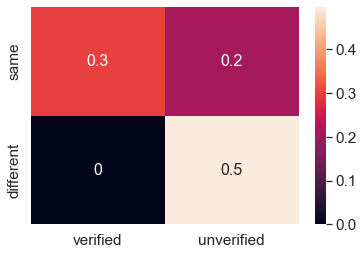

In [18]:
TP=len([x for x in results if x[1]]) / (len(results) + len(results_neg))
FN=len([x for x in results if not x[1]]) / (len(results) + len(results_neg))
FP=len([x for x in results_neg if x[1]]) / (len(results) + len(results_neg))
TN=len([x for x in results_neg if not x[1]]) / (len(results) + len(results_neg))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TP,FN],
         [FP,TN]]

df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [41]:
from sklearn import svm
X = [x[2] for x in results] + [x[2] for x in results_neg]
y = [1 for x in results] + [0 for x in results_neg]
clf = svm.SVC() #kernel="linear")
clf.fit(np.array(X).reshape(-1, 1), y)

SVC()

In [42]:
ps=clf.predict(np.array([x[2] for x in results]).reshape(-1, 1))

In [43]:
len([x for x in ps if x == 1])

84

In [44]:
ns=clf.predict(np.array([x[2] for x in results_neg]).reshape(-1, 1))

In [45]:
np.array([x[2] for x in results + results_neg])

array([0.52577713, 0.53211343, 0.56727874, 0.62083387, 0.47772884,
       0.56106615, 0.68205959, 0.55979753, 0.38284594, 0.32652766,
       0.43790096, 0.6852341 , 0.21677274, 0.31561142, 0.58910519,
       0.44509125, 0.46825451, 0.44950068, 0.38989669, 0.41358531,
       0.44444531, 0.39289641, 0.54150048, 0.42196429, 0.44786459,
       0.5014444 , 0.46243727, 0.56206062, 0.5538184 , 0.46749425,
       0.44382346, 0.62209469, 0.53377789, 0.55062571, 0.35890543,
       0.49958116, 0.33034217, 0.48348933, 0.33282655, 0.4463957 ,
       0.49409711, 0.36091995, 0.46830213, 0.49081141, 0.5035603 ,
       0.35753793, 0.42805946, 0.55670542, 0.61986634, 0.531773  ,
       0.5347518 , 0.72656417, 0.46619898, 0.39121962, 0.28890282,
       0.43559325, 0.45610541, 0.4280709 , 0.46800113, 0.40254676,
       0.51631796, 0.55060127, 0.57322532, 0.54880482, 0.46069205,
       0.57084188, 0.51918966, 0.42171144, 0.54270539, 0.52810135,
       0.50245449, 0.6135557 , 0.48840958, 0.43180883, 0.50315

In [46]:
len([x for x in ps if x == 0])

7

In [47]:
len(ps)

91

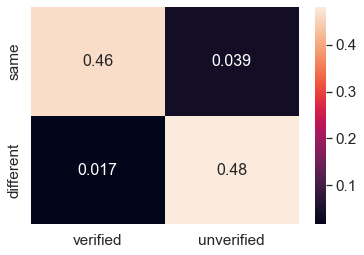

In [48]:
TP=len([x for x in ps if x]) / (len(results) + len(results_neg))
FN=len([x for x in ps if not x]) / (len(results) + len(results_neg))
FP=len([x for x in ns if x]) / (len(results) + len(results_neg))
TN=len([x for x in ns if not x]) / (len(results) + len(results_neg))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[TP,FN],
         [FP,TN]]

df_cm = pd.DataFrame(array, ['same', 'different'], ['verified', 'unverified'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [36]:
TP

0.46408839779005523

In [37]:
FN

0.03867403314917127

In [38]:
FP

0.027624309392265192

In [39]:
len(results) + len(results_neg)

181

In [58]:
[(0.59+x/1000,clf.predict(np.array(0.59+x/1000).reshape(-1, 1))) for x in range(10)]

[(0.59, array([1])),
 (0.591, array([1])),
 (0.592, array([1])),
 (0.593, array([1])),
 (0.594, array([1])),
 (0.595, array([1])),
 (0.596, array([1])),
 (0.597, array([1])),
 (0.598, array([0])),
 (0.599, array([0]))]